In [ ]:
import bpy 
import numpy as np 
import os 
import sys
sys.path.append('/Volumes/Data/GitLab/Blender-renderer')
import util 

class BlenderInterface():
    def __init__(self, resolution=128):
        self.resolution = resolution

        # Delete the default cube (default selected)
        bpy.ops.object.delete()
        
        # Set the world background to white 
        world = bpy.context.scene.world
        world.use_nodes = True
        bg_node = world.node_tree.nodes['Background']
        bg_node.inputs[0].default_value = (0, 0, 0, 1) 
        bpy.context.scene.view_settings.view_transform = 'Raw'

        # Deselect all. All new object added to the scene will automatically selected.
        self.blender_renderer = bpy.context.scene.render
        self.blender_renderer.resolution_x = resolution
        self.blender_renderer.resolution_y = resolution
        self.blender_renderer.resolution_percentage = 100
        self.blender_renderer.image_settings.file_format = 'PNG'  # set output format to .png
        self.blender_renderer.film_transparent = True
        self.blender_renderer.image_settings.color_mode = "RGB"
        
        # set up lighting 
        has_light = any(obj.type == 'LIGHT' for obj in bpy.context.scene.objects)
        if not has_light:
            self.lamp1 = bpy.data.lights.new(name="Light", type='SUN')
            light_object = bpy.data.objects.new("Light", self.lamp1)
            bpy.context.collection.objects.link(light_object)
        self.lamp1 = bpy.data.lights['Light']
        self.lamp1.type = 'SUN'
        self.lamp1.use_shadow = False
        self.lamp1.specular_factor = 0.0
        
        self.lamp1 = bpy.data.objects['Light']
        #self.lamp1.location = (2, 0, 10)
        self.lamp1.data.energy = 5.459948539733887
        self.lamp1.rotation_euler = (0.0, 0.0, 0.0)#(-12.031*np.pi/180, 39.282*np.pi/180, 0)
        self.lamp1.data.angle = 0.0

        # Set up the camera
        self.camera = bpy.context.scene.camera
        self.camera.data.sensor_height = self.camera.data.sensor_width # Square sensor
        util.set_camera_focal_length_in_world_units(self.camera.data, 525./512*resolution) # Set focal length to a common value (kinect)
        
        bpy.context.scene.render.engine = 'BLENDER_EEVEE'
        bpy.context.scene.eevee.use_gtao = True
        bpy.context.scene.eevee.taa_render_samples = 64

        # set up for output depth information 
        bpy.context.view_layer.use_pass_z = True
        bpy.context.scene.use_nodes = True
        tree = bpy.context.scene.node_tree
        for node in tree.nodes:
            tree.nodes.remove(node)
        render_layers = tree.nodes.new('CompositorNodeRLayers')
        composite = tree.nodes.new('CompositorNodeComposite')
        normalize = tree.nodes.new('CompositorNodeNormalize')
        alphaover = tree.nodes.new('CompositorNodeAlphaOver')

        bpy.data.scenes["Scene"].node_tree.nodes["Composite"].use_alpha = False
        self.depth_output = tree.nodes.new('CompositorNodeOutputFile')
        self.depth_output.format.file_format = "PNG"
        self.depth_output.format.color_mode = 'BW'

        tree.links.new(render_layers.outputs['Image'], alphaover.inputs[2])
        tree.links.new(alphaover.outputs['Image'] ,composite.inputs['Image'])
        tree.links.new(render_layers.outputs['Depth'], normalize.inputs[0])
        tree.links.new(normalize.outputs[0], self.depth_output.inputs[0])
          
        bpy.data.objects['Camera'].visible_shadow = True
        bpy.ops.object.select_all(action='DESELECT')

    def import_mesh(self, fpath, scale=1., object_world_matrix=None):
        ext = os.path.splitext(fpath)[-1] 
        bpy.ops.wm.obj_import(filepath=str(fpath))

        obj = bpy.context.selected_objects[0]
        #bpy.context.object.display.show_shadows = False

        """
        In the original repo, this object_world_matrix thing was used. 
        However, this should be omitted in order to render the same 
        image as used in SMR datasets given their poses.
        (This also affect how we set up the light sources.)
        """
        # if object_world_matrix is not None:
        #     obj.matrix_world = object_world_matrix
            

        bpy.ops.object.origin_set(type='ORIGIN_GEOMETRY', center='BOUNDS')
        obj.location = (0., 0., 0.) # center the bounding box!
            
        # fix the material problem (maybe)
        for mat in bpy.data.materials:
            mat.use_backface_culling = False

        if scale != 1.:
            bpy.ops.transform.resize(value=(scale, scale, scale))

        # Disable transparency & specularities
        M = bpy.data.materials
        for i in range(len(M)):
            M[i].blend_method = 'OPAQUE'
            M[i].specular_intensity = 0.0
            
    def render(self, output_dir, blender_cam2world_matrices, write_cam_params=False):
        
        if write_cam_params: 
            img_dir = os.path.join(output_dir, 'rgb')
            pose_dir = os.path.join(output_dir, 'pose')
            depth_dir = os.path.join(output_dir, 'depth')
            
            util.cond_mkdir(img_dir)
            util.cond_mkdir(pose_dir)
            util.cond_mkdir(depth_dir)
        else:
            img_dir = output_dir
            util.cond_mkdir(img_dir)
            
        # save intrinsic params 
        if write_cam_params:
            K = util.get_calibration_matrix_K_from_blender(self.camera.data)
            with open(os.path.join(output_dir, 'intrinsics.txt'),'w') as intrinsics_file:
                intrinsics_file.write('%f %f %f 0.\n'%(K[0][0], K[0][2], K[1][2]))
                intrinsics_file.write('0. 0. 0.\n')
                intrinsics_file.write('1.\n')
                intrinsics_file.write('%d %d\n'%(self.resolution, self.resolution))

        for i in range(len(blender_cam2world_matrices)):
            self.camera.matrix_world = blender_cam2world_matrices[i]

            # Render the object
            if os.path.exists(os.path.join(img_dir, '%06d.png' % i)):
                continue
            
            # set z-depth output directory 
            self.depth_output.base_path = depth_dir
            
            # Render the color image
            self.blender_renderer.filepath = os.path.join(img_dir, '%06d.png'%i)
            bpy.ops.render.render(write_still=True, use_viewport=True)

            if write_cam_params:
                # Write out camera pose
                RT = util.get_world2cam_from_blender_cam(self.camera)
                cam2world = RT.inverted()
                with open(os.path.join(pose_dir, '%06d.txt'%i),'w') as pose_file:
                    matrix_flat = []
                    for j in range(4):
                        for k in range(4):
                            matrix_flat.append(cam2world[j][k])
                    pose_file.write(' '.join(map(str, matrix_flat)) + '\n')
                    
            # rename the depth map since it's given a stupid default name by Blender
            
            stupid_default_name = os.path.join(depth_dir, 'Image0001.png')
            new_name = os.path.join(depth_dir, f'{i:06d}.png')
            os.system(f"mv {stupid_default_name} {new_name}")

        # Remember which meshes were just imported
        meshes_to_remove = []
        for ob in bpy.context.selected_objects:
            meshes_to_remove.append(ob.data)

        bpy.ops.object.delete()

        # Remove the meshes from memory too
        for mesh in meshes_to_remove:
            bpy.data.meshes.remove(mesh)

In [1]:
import os 
import numpy as np 

file_path = "/Users/brianwang/Downloads/ShapeNetCore.v2/02958343/10555502fa7b3027283ffcfc40c29975/models/model_normalized.obj"
os.path.splitext(file_path)

('/Users/brianwang/Downloads/ShapeNetCore.v2/02958343/10555502fa7b3027283ffcfc40c29975/models/model_normalized',
 '.obj')

In [2]:
dir(file_path)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'removeprefix',
 'removesuffix',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',


In [3]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [4]:
def normalize(vec):
    return vec / (np.linalg.norm(vec, axis=-1, keepdims=True) + 1e-9)

def sample_spherical(n, radius=1.):
    xyz = np.random.normal(size=(n,3))
    xyz = normalize(xyz) * radius
    return xyz

sample_spherical(10, 1.)

array([[ 0.40834152,  0.4612368 ,  0.78772953],
       [ 0.44092225,  0.43769254,  0.78358969],
       [ 0.50563371,  0.41809049,  0.75467536],
       [-0.27674362, -0.2403482 , -0.93040083],
       [ 0.93533021, -0.03368931, -0.35216817],
       [ 0.84051288,  0.12671852, -0.52676419],
       [-0.86622612,  0.36856434,  0.33736128],
       [ 0.51291731,  0.57679459,  0.635786  ],
       [ 0.36114383, -0.11881948, -0.92490922],
       [ 0.91186307, -0.16339708,  0.37657287]])

In [13]:
x = '/Users/brianwang/Downloads/buffer/depth/000000.npz'
x = '/Users/brianwang/Downloads/buffer/02958343/100c3076c74ee1874eb766e5a46fceab/depth/000002.npz'

with np.load(x) as data: 
    dmap = data['dmap']
    
import matplotlib.pyplot as plt 
plt.imshow(dmap, cmap='gray')
plt.colorbar()
plt.show()

dmap.max(), dmap.min()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/brianwang/Downloads/buffer/02958343/100c3076c74ee1874eb766e5a46fceab/depth/000002.npz'

0 13933 (1024, 1024)


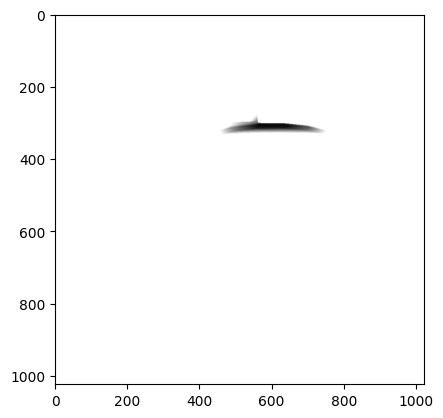

In [23]:
x = '/Users/brianwang/Downloads/buffer/depth/000002.npz'
x = '/Users/brianwang/Downloads/buffer/depth/0000060001.png'

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt 

x = '/Users/brianwang/Downloads/buffer/depth/000002.png'
image = Image.open(x)
image_array = np.array(image)
plt.imshow(image)
print(image_array.min(), image_array.max(), image_array.shape)




In [43]:
dmap

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [5]:
input_dir = "/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000008.npz"

file_path, filename = os.path.split(input_dir)
old_folder_split = file_path.split('/')
old_folder_split[-1] = "depth_image"
new_path = '/'.join(old_folder_split)
output_dir = os.path.join(new_path, filename)
print("New Output Directory:", output_dir)

['', 'Users', 'brianwang', 'Downloads', 'buffer', '02871439', '104874322c6f7a75aba93753eed86c0a', 'depth_image']
New Output Directory: /Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth_image/000008.npz


In [13]:
import subprocess

input_dir="/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a"
input_directories = subprocess.getoutput(f'find {input_dir} -name "*.npz"')
input_directories = input_directories.split('\n')
input_directories

['/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000008.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000009.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000007.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000006.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000004.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000005.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000001.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000000.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000002.npz',
 '/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000003.npz']

In [25]:


with np.load('/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth/000008.npz') as data: 
    dmap = data['dmap']
dmap.min()


0.0

In [ ]:
import cv2
import matplotlib.pyplot as plt 
image = cv2.imread('/Users/brianwang/Downloads/buffer/02871439/104874322c6f7a75aba93753eed86c0a/depth_image/000008.png')
image.max()
dmap_normalized = cv2.normalize(dmap, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [14]:
import numpy as np 

file_path = '/Users/brianwang/Downloads/buffer/02958343/f8b92a0ea7f4705c9fec71e8f4aac226/pose/000000.txt'

def read_pose(file_path):
    cam_loc = []
    with open(file_path, 'r') as file:
        for line in file:
            numbers = line.strip().split(" ")  
            for number in numbers: 
                cam_loc.append(number)
    cam_pose = np.array(cam_loc).reshape(4, 4).astype('float')
    return cam_pose

cam_pose = read_pose(file_path)


In [37]:
import imageio.v2 as imageio
img1 = imageio.imread("/Users/brianwang/Downloads/buffer2/rgb/000000.png")
img2 = imageio.imread("/Users/brianwang/Downloads/f8b92a0ea7f4705c9fec71e8f4aac226/rgb/000000.png")

def mse(img1, img2):
    return np.mean((img1.flatten() - img2.flatten())**2)

mse(img1, img2)


7.3838348388671875

In [72]:
with open('/Users/brianwang/Downloads/output.txt', 'w'):
    pass


In [48]:
with open("/Users/brianwang/Downloads/output.txt", 'a') as f:
    f.write('df' + '\n')


In [52]:
print(f'{12.111111:.3f}')

12.111


In [59]:
img2_dir = "/Users/brianwang/Downloads/f8b92a0ea7f4705c9fec71e8f4aac226/rgb/000000.png"




In [65]:
import os 
    
img2_base_dir = "/Users/brianwang/Downloads/f8b92a0ea7f4705c9fec71e8f4aac226/rgb"
img2_dirs = [os.path.join(img2_base_dir, str(x).zfill(6)) + ".png" for x in range(0, 250, 20)]

In [71]:
obj_dir = '/Users/brianwang/Downloads/ShapeNetCore.v2/02958343/f8b92a0ea7f4705c9fec71e8f4aac226/models/model_normalized.obj'
pose_base_dir = '/Users/brianwang/Downloads/f8b92a0ea7f4705c9fec71e8f4aac226/pose/'
intrinsic_dir = ''
output_dir = '/Users/brianwang/Downloads/buffer2'

img1_dir = "/Users/brianwang/Downloads/buffer2/rgb/000000.png"
img2_base_dir = "/Users/brianwang/Downloads/f8b92a0ea7f4705c9fec71e8f4aac226/rgb"
img2_dirs = [os.path.join(img2_base_dir, str(x).zfill(6)) + ".png" for x in range(0, 250, 50)]
pose_dirs = [os.path.join(pose_base_dir, str(x).zfill(6)) + ".txt" for x in range(0, 250, 50)]
print(len(img2_dirs), len(pose_dirs))

5 5


In [73]:
np.sign(-2)

-1

In [1]:
import os 
import numpy as np 

param_file = '/Users/brianwang/Downloads/params.npz'

with np.load(param_file) as params:
    energy = params['energy']
    rotx = params['rotx']
    roty = params['roty']
    angle = params['angle']
    energy2 = params['energy2']
    rotx2 = params['rotx2']
    roty2 = params['roty2']
    angle2 = params['angle2']
    data = params
    print
    
energy


array(4.77876163)

In [11]:
print('energy:', energy)
print('rotx:', rotx)
print('roty:', roty)
print('angle:', angle)
print('energy2:', energy2)
print('rotx2:', rotx2)
print('roty2:', roty2)
print('angle2:', angle2)

energy: 4.778761632087958
rotx: -0.009755409066659329
roty: 0.1952525724709777
angle: 0.43700644993115656
energy2: 2.070866401341689
rotx2: -0.0023518663770742965
roty2: 0.3196567690372467
angle2: 0.525242442911481


In [23]:
for i in range(0, 20, 20):
    print(i)

0


In [51]:
import os 
import numpy as np 

#obj_dir = '/Volumes/Data/GitLab/Blender-renderer/SRN_object_part'
img_dir = '/Volumes/Data/GitLab/Blender-renderer/SRN_Dataset_part'
output_dir = '/Volumes/Data/GitLab/Blender-renderer/SRN_new_render'
obj_dir = '/Volumes/Data/GitLab/Blender-renderer/SRN_object_part'

def get_subdirectories(base_dir, directory=True):
    subdirectories = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if (not directory) or os.path.isdir(os.path.join(base_dir, d))]
    return subdirectories

# 1. save pose 
# 2. save original image 
# 3. save new rendered image 

def save_pose(choosed_poses):
    for i in choosed_poses:
        saved_location = os.path.join(*i.split('/')[-3:-1])
        saved_location = os.path.join(output_dir, saved_location)
        if not os.path.exists(saved_location):
            os.makedirs(saved_location)
        os.system(f"cp {i} {saved_location}")
    return poses 
        
def save_img(choosed_poses):
    for i in choosed_poses:
        base_dir = os.path.join(*i.split('/')[:-2], 'rgb')
        item_num = i.split('/')[-1].split('.')[0]
        img = os.path.join(base_dir, item_num + ".png")
        saved_location = os.path.join(*img.split('/')[-3:-1])
        saved_location = os.path.join(output_dir, saved_location)
        if not os.path.exists(saved_location):
            os.makedirs(saved_location)
        os.system(f"cp /{img} {saved_location}")
        
def get_obj_path(obj):
    obj_name = obj.split('/')[-1]
    return os.path.join(obj_dir, obj_name, "models/model_normalized.obj")

def save_obj(pose_path):
    save_path = os.path.join(output_dir, pose_path.split('/')[-3], "new_rendered")
    temp_save_path = os.path.join(save_path, "buffer")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    original_png_path = os.path.join(temp_save_path, "rgb/000000.png")
    png_name = (pose_path.split('/')[-1]).split('.')[0]
    new_png_path = os.path.join(save_path, f"{png_name}.png")
    
    os.system(f"mv {original_png_path} {new_png_path}")
    os.system(f"rm -rf {temp_save_path}")
    return temp_save_path
    
    
   
os.system(f"rm -rf {output_dir}")
os.mkdir(output_dir)     

pose_num = 5
obj_num = 10    
objects = np.random.choice(get_subdirectories(img_dir), obj_num, replace=False).tolist()

for obj in objects: 
    pose_path = os.path.join(obj, 'pose')
    poses = get_subdirectories(pose_path, directory=False)
    choosed_poses = np.random.choice(poses, pose_num, replace=False).tolist()
    
    save_img(choosed_poses)
    save_pose(choosed_poses)
    
    obj_path = get_obj_path(obj)
    for pose_path in choosed_poses:
        result = save_obj(pose_path)

# location the object and render it 

In [52]:
result

'/Volumes/Data/GitLab/Blender-renderer/SRN_new_render/a34260b8cdb1ec95b63de680261b9e1b/new_rendered/buffer'